<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup-MongoDB-Connection" data-toc-modified-id="Setup-MongoDB-Connection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup MongoDB Connection</a></span></li><li><span><a href="#Creating-a-dataframe-of-Manhattan-Buildings-(from-MongoDB)" data-toc-modified-id="Creating-a-dataframe-of-Manhattan-Buildings-(from-MongoDB)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Creating a dataframe of Manhattan Buildings (from MongoDB)</a></span></li><li><span><a href="#Data-Analysis" data-toc-modified-id="Data-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Analysis</a></span><ul class="toc-item"><li><span><a href="#KMeans--Clustering" data-toc-modified-id="KMeans--Clustering-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>KMeans  Clustering</a></span></li><li><span><a href="#Try-Kmodes---to-cluster-on-categorical-variables" data-toc-modified-id="Try-Kmodes---to-cluster-on-categorical-variables-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Try <a href="https://github.com/nicodv/kmodes" target="_blank">Kmodes</a> - to cluster on categorical variables</a></span></li><li><span><a href="#Guassian-Mixture-Models" data-toc-modified-id="Guassian-Mixture-Models-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Guassian Mixture Models</a></span></li></ul></li></ul></div>

# K-Means Clustering of NYC Pluto Data
April 4th

## Setup MongoDB Connection

In [128]:
#load python dependencies
import pandas as pd
import pprint as pp
import json
import string
from bson import json_util, ObjectId
from pandas.io.json import json_normalize
import math

In [3]:
#connect to mongodb
from pymongo import MongoClient
client = MongoClient()
db = client.thesis #thesis is the name of the DB we want to access

In [4]:
# get the names of collections in MongoDB
db.collection_names(include_system_collections=False)

['features', 'pluto']

In [8]:
features = db.features

In [6]:
# find one from Manhattan Borough
pp.pprint(features.find_one({'properties.Borough':'MN'}))

{'_id': ObjectId('5ab26407168e4a911bf9c754'),
 'geometry': {'coordinates': [[[-74.00030834856233, 40.7481450543048],
                               [-74.00064119170582, 40.74828487041532],
                               [-74.00045799651024, 40.7485340197782],
                               [-74.00012815525666, 40.748395452549445],
                               [-74.00030834856233, 40.7481450543048]]],
              'type': 'Polygon'},
 'properties': {'APPBBL': 1007230041,
                'APPDate': '11/30/2006',
                'Address': '263 9 AVENUE',
                'AreaSource': '2',
                'AssessLand': 539990,
                'AssessTot': 10493435,
                'BBL': 1007237501,
                'BldgArea': 89203,
                'BldgClass': 'R4',
                'BldgDepth': 100,
                'BldgFront': 87,
                'Block': 723,
                'BoroCode': 1,
                'Borough': 'MN',
                'BsmtCode': '5',
                'BuiltFAR':

In [5]:
# Specify fields wanted
fields = {"properties.Borough" : 1,
            "properties.Address" : 1,
              "properties.BldgArea" : 1,
              "properties.BldgClass" : 1,
              "properties.Block" : 1,
              "properties.BoroCode" : 1,
              "properties.LandUse" : 1,
              "properties.LotArea" : 1,
              "properties.NumFloors" : 1,
              "properties.UnitsRes" : 1,
              "properties.UnitsTotal" : 1 ,
              "properties.OwnerName" : 1,
              "properties.YearBuilt": 1,
              "properties.CD" : 1,
              "properties.ResidFAR": 1,
              "properties.FacilFAR": 1, 
              "properties.BuiltFAR": 1,
              "properties.CommFAR": 1,
              "properties.Landmark": 1,
              "properties.UnitsTotal": 1,
              "properties.AssessTot": 1
          
         }
            

In [8]:
features.find_one({'properties.Borough':'MN'}, fields)

{'_id': ObjectId('5ab26407168e4a911bf9c754'),
 'properties': {'Address': '263 9 AVENUE',
  'AssessTot': 10493435,
  'BldgArea': 89203,
  'BldgClass': 'R4',
  'Block': 723,
  'BoroCode': 1,
  'Borough': 'MN',
  'BuiltFAR': 9.03,
  'CD': 104,
  'FacilFAR': 6.5,
  'LandUse': '03',
  'Landmark': None,
  'LotArea': 9875,
  'NumFloors': 11,
  'OwnerName': None,
  'ResidFAR': 6.02,
  'UnitsRes': 50,
  'UnitsTotal': 50,
  'YearBuilt': 1914}}

## Creating a dataframe of Manhattan Buildings (from MongoDB)

In [6]:
def mongo_to_dataframe(mongo_data):

        sanitized = json.loads(json_util.dumps(mongo_data))
        
        # unnests the json data
        normalized = json_normalize(sanitized)
        
        #creates a data frame
        df = pd.DataFrame(normalized)
        
        #cleans up column names
        df.columns = df.columns.str.replace('properties.', '')

        return df

In [9]:
df = mongo_to_dataframe(features.find({'properties.Borough':'MN'}, fields))

In [1]:
print(df.shape)
df.head()

NameError: name 'df' is not defined

## Data Analysis

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import re

In [51]:
landUseMapping = {
  "01": {"name": "One &Two Family Buildings", "color": ""},
  "02": {"name": "Multi-Family Walk-Up Buildings", "color": ""},
  "03": {"name": "Multi-Family Elevator Buildings", "color": ""},
  "04": {"name": "Mixed Residential & Commercial Buildings", "color": ""},
  "05": {"name": "Commercial & Office Buildings", "color": ""},
  "06": {"name": "Industrial & Manufacturing", "color": ""},
  "07": {"name": "Transportation & Utility", "color": ""},
  "08": {"name": "Public Facilities & Institutions", "color": ""},
  "09": {"name": "Open Space & Outdoor Recreation", "color": ""},
  "10": {"name": "Parking Facilities", "color": ""},
  "11": {"name": "Vacant Land", "color": ""}
}

In [21]:
list(df)

['_id.$oid',
 'Address',
 'AssessTot',
 'BldgArea',
 'BldgClass',
 'Block',
 'BoroCode',
 'Borough',
 'BuiltFAR',
 'CD',
 'CommFAR',
 'FacilFAR',
 'LandUse',
 'Landmark',
 'LotArea',
 'NumFloors',
 'OwnerName',
 'ResidFAR',
 'UnitsRes',
 'UnitsTotal',
 'YearBuilt',
 'allotedFar']

In [11]:
# add column calculating the variance from alotted FAR
df['allotedFAR'] = df[['FacilFAR', 'ResidFAR', 'CommFAR']].max(leftAxis=1)
# df.head()


,_id.$oid,Address,AssessTot,BldgArea,BldgClass,Block,BoroCode,Borough,BuiltFAR,CD,...,LandUse,Landmark,LotArea,NumFloors,OwnerName,ResidFAR,UnitsRes,UnitsTotal,YearBuilt,allotedFAR
0,5ab26407168e4a911bf9c754,263 9 AVENUE,10493435,89203,R4,723,1,MN,9.03,104,...,03,None,9875,11.0,None,6.02,50,50,1914,6.5
1,5ab26407168e4a911bf9c755,1592 2 AVENUE,1588500,10885,C7,1545,1,MN,3.93,108,...,04,None,2767,5.0,LL 1592 SECOND AVENUE,10.00,16,18,1920,10.0
2,5ab26407168e4a911bf9c756,310 EAST 109 STREET,370732,12000,C1,1680,1,MN,4.76,111,...,02,None,2523,5.0,LA CASA NUESTRA HOUSI,4.00,10,10,1910,4.0
3,5ab26407168e4a911bf9c757,720 PARK AVENUE,29849400,203490,D4,1385,1,MN,13.51,108,...,03,None,15062,17.0,720 PARK AVE CORP - B,10.00,29,32,1928,10.0
4,5ab26407168e4a911bf9c758,181 GRAND STREET,29859,2733,S2,236,1,MN,1.92,102,...,04,None,1425,3.0,GELSO 3 LLC,6.02,2,3,1910,6.5


In [12]:
df['amountOverAllotedFAR'] = df['allotedFAR'] - df['BuiltFAR']
# df.head()

In [77]:
# create simplified label for buildingClass
df['simpleBldgClass'] = df['BldgClass'].str[0:1]
# df.head()

,_id.$oid,Address,AssessTot,BldgArea,BldgClass,Block,BoroCode,Borough,BuiltFAR,CD,...,LotArea,NumFloors,OwnerName,ResidFAR,UnitsRes,UnitsTotal,YearBuilt,allotedFAR,amountOverAllotedFAR,simpleBldgClass
0,5ab26407168e4a911bf9c754,263 9 AVENUE,10493435,89203,R4,723,1,MN,9.03,104,...,9875,11.0,None,6.02,50,50,1914,6.5,-2.53,R
1,5ab26407168e4a911bf9c755,1592 2 AVENUE,1588500,10885,C7,1545,1,MN,3.93,108,...,2767,5.0,LL 1592 SECOND AVENUE,10.00,16,18,1920,10.0,6.07,C
2,5ab26407168e4a911bf9c756,310 EAST 109 STREET,370732,12000,C1,1680,1,MN,4.76,111,...,2523,5.0,LA CASA NUESTRA HOUSI,4.00,10,10,1910,4.0,-0.76,C
3,5ab26407168e4a911bf9c757,720 PARK AVENUE,29849400,203490,D4,1385,1,MN,13.51,108,...,15062,17.0,720 PARK AVE CORP - B,10.00,29,32,1928,10.0,-3.51,D
4,5ab26407168e4a911bf9c758,181 GRAND STREET,29859,2733,S2,236,1,MN,1.92,102,...,1425,3.0,GELSO 3 LLC,6.02,2,3,1910,6.5,4.58,S


In [89]:
#create Residential units / Total units ratio
df['resUnitRatio'] = df['UnitsRes']/df['UnitsTotal']

count    4.263800e+04
mean     4.138599e+04
std      1.603490e+05
min      0.000000e+00
25%      4.399250e+03
50%      8.870000e+03
75%      2.280875e+04
max      1.343508e+07
Name: BldgArea, dtype: float64

In [147]:
df['logBldgArea'] = df['BldgArea'].apply(lambda x: math.log(x) if x > 0 else 0)
df['logLotArea'] = df['LotArea'].apply(lambda x: math.log(x) if x > 0 else 0)
df.head()

,_id.$oid,Address,AssessTot,BldgArea,BldgClass,Block,BoroCode,Borough,BuiltFAR,CD,...,ResidFAR,UnitsRes,UnitsTotal,YearBuilt,allotedFAR,amountOverAllotedFAR,simpleBldgClass,resUnitRatio,logBldgArea,logLotArea
0,5ab26407168e4a911bf9c754,263 9 AVENUE,10493435,89203,R4,723,1,MN,9.03,104,...,6.02,50,50,1914,6.5,-2.53,R,1.000000,11.398670,9.197762
1,5ab26407168e4a911bf9c755,1592 2 AVENUE,1588500,10885,C7,1545,1,MN,3.93,108,...,10.00,16,18,1920,10.0,6.07,C,0.888889,9.295141,7.925519
2,5ab26407168e4a911bf9c756,310 EAST 109 STREET,370732,12000,C1,1680,1,MN,4.76,111,...,4.00,10,10,1910,4.0,-0.76,C,1.000000,9.392662,7.833204
3,5ab26407168e4a911bf9c757,720 PARK AVENUE,29849400,203490,D4,1385,1,MN,13.51,108,...,10.00,29,32,1928,10.0,-3.51,D,0.906250,12.223372,9.619930
4,5ab26407168e4a911bf9c758,181 GRAND STREET,29859,2733,S2,236,1,MN,1.92,102,...,6.02,2,3,1910,6.5,4.58,S,0.666667,7.913155,7.261927


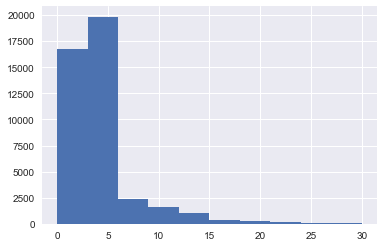

In [176]:
df[df['BuiltFAR']<30].BuiltFAR.hist()

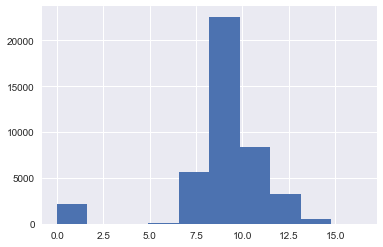

In [135]:
df.logBldgArea.hist()

### KMeans  Clustering

Drawbacks: 

    - won't select number of clusters for you
    - limited to linear cluster boundaries
    - uses Euclidean Distance which means that it cannot be used with categorical variables
    

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [46]:
#prepare df for clustering
X = df[['amountOverAllotedFAR', 'YearBuilt', 'UnitsTotal', 'UnitsRes', 'logLotArea', 'logBldgArea', 'LandUse']]
X = X[X['YearBuilt'] > 1870]
X = X.dropna()
X.head()


,amountOverAllotedFAR,YearBuilt,UnitsTotal,UnitsRes,LotArea,BldgArea,LandUse
0,-2.53,1914,50,50,9875,89203,03
1,6.07,1920,18,16,2767,10885,04
2,-0.76,1910,10,10,2523,12000,02
3,-3.51,1928,32,29,15062,203490,03
4,4.58,1910,3,2,1425,2733,04


In [47]:
n_clusters = 10
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(X)

In [48]:
X['kmeans'] = cluster_labels

In [49]:
X['kmeans'].value_counts()

0    35855
5     3156
4      801
1      241
6       62
8        9
9        2
3        2
2        2
7        1
Name: kmeans, dtype: int64

In [54]:
list(X)

['amountOverAllotedFAR',
 'YearBuilt',
 'UnitsTotal',
 'UnitsRes',
 'LotArea',
 'BldgArea',
 'LandUse',
 'kmeans']

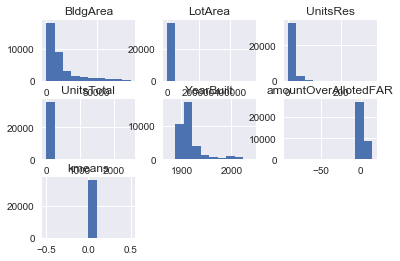

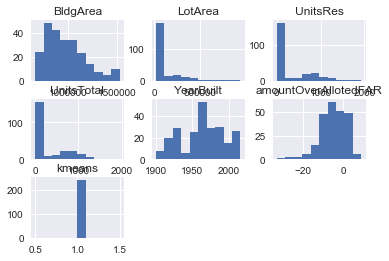

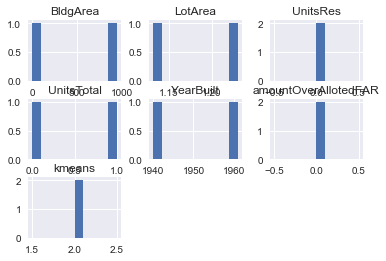

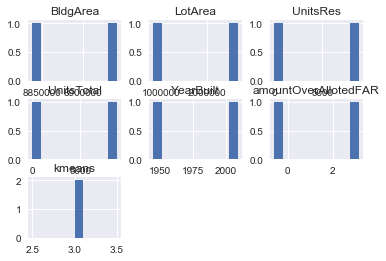

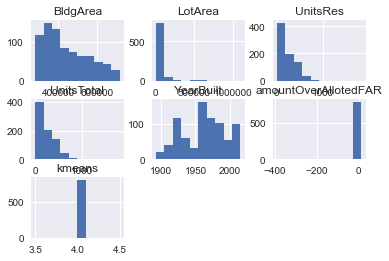

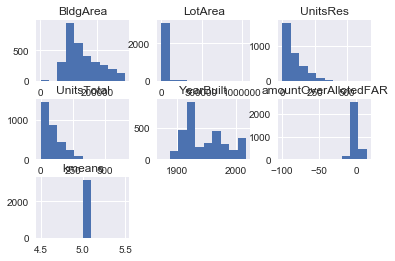

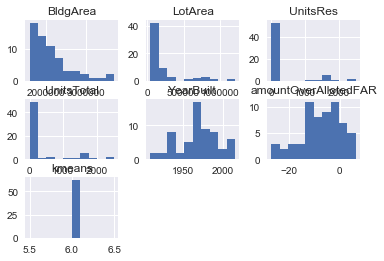

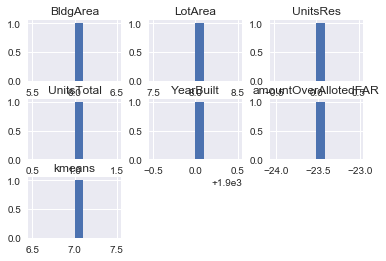

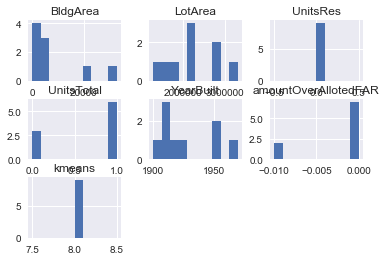

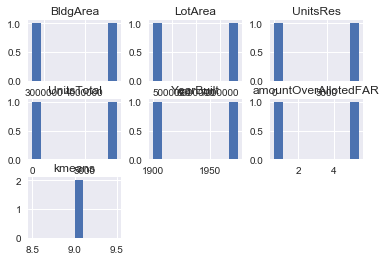

In [53]:
for n in range(n_clusters):
    plt.figure()
    X[X.kmeans == n].hist()

### Try [Kmodes](https://github.com/nicodv/kmodes) - to cluster on categorical variables 

[link](https://arxiv.org/ftp/cs/papers/0603/0603120.pdf) to paper 

[another link](http://www.cs.ust.hk/~qyang/Teaching/537/Papers/huang98extensions.pdf) 

In [55]:
from kmodes.kmodes import KModes

In [138]:
#prepare df for clustering
X = df[['simpleBldgClass', 
        'amountOverAllotedFAR', 
        'YearBuilt', 
        'resUnitRatio', 
        'logLotArea', 
        'logBldgArea', 
        'LandUse']]

X = X[X['YearBuilt'] > 1870] ## filter out null vals and year = 0
X = X[X['resUnitRatio'] < 1] ## unclear what those mean 
X = X.dropna()
X.head()

,simpleBldgClass,amountOverAllotedFAR,YearBuilt,resUnitRatio,logLotArea,logBldgArea,LandUse
1,C,6.07,1920,0.888889,7.925519,9.295141,04
3,D,-3.51,1928,0.906250,9.619930,12.223372,03
4,S,4.58,1910,0.666667,7.261927,7.913155,04
7,O,3.78,1920,0.000000,7.588324,9.416134,05
9,D,-1.98,1922,0.948718,8.808668,10.597884,04


In [144]:
n_clusters = 8
km = KModes(n_clusters=n_clusters, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(X)

print(km.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 6030, cost: 105070.0
Run 1, iteration: 2/100, moves: 1487, cost: 104146.0
Run 1, iteration: 3/100, moves: 354, cost: 104108.0
Run 1, iteration: 4/100, moves: 12, cost: 104108.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 5186, cost: 103270.0
Run 2, iteration: 2/100, moves: 2703, cost: 101732.0
Run 2, iteration: 3/100, moves: 470, cost: 101652.0
Run 2, iteration: 4/100, moves: 7, cost: 101652.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 5127, cost: 110876.0
Run 3, iteration: 2/100, moves: 42, cost: 110876.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 2858, cost: 103927.0
Run 4, iteration: 2/100, moves: 899, cost: 103734.0
Run 4, iteration: 3/100, moves: 8, cost: 103734.0
Init

In [145]:
X['kmodes'] = clusters
X.head()

,simpleBldgClass,amountOverAllotedFAR,YearBuilt,resUnitRatio,logLotArea,logBldgArea,LandUse,kmodes
1,C,6.07,1920,0.888889,7.925519,9.295141,04,1
3,D,-3.51,1928,0.906250,9.619930,12.223372,03,0
4,S,4.58,1910,0.666667,7.261927,7.913155,04,4
7,O,3.78,1920,0.000000,7.588324,9.416134,05,7
9,D,-1.98,1922,0.948718,8.808668,10.597884,04,2


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


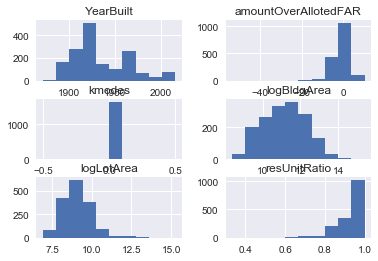

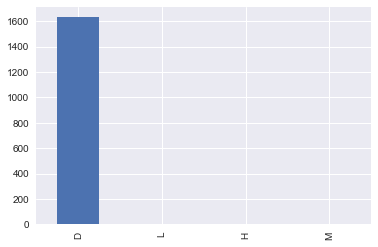

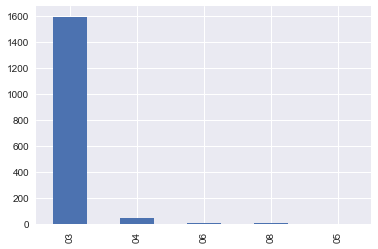

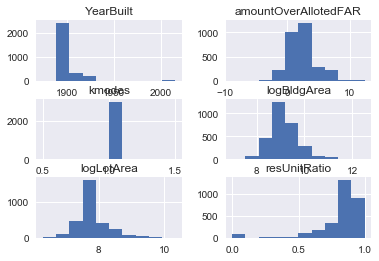

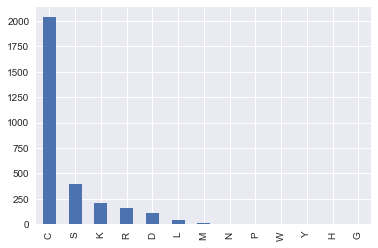

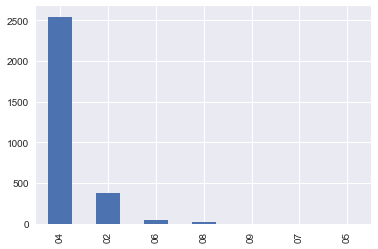

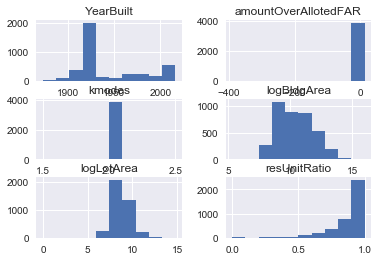

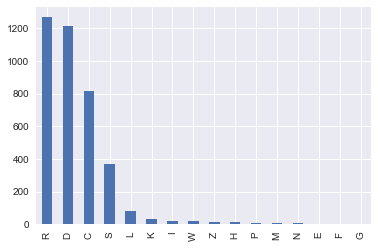

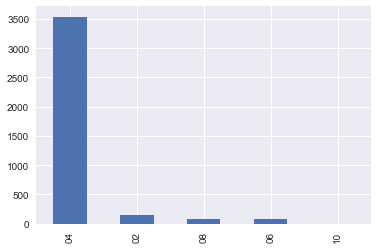

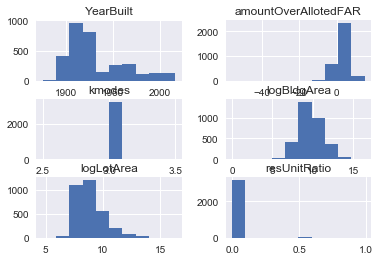

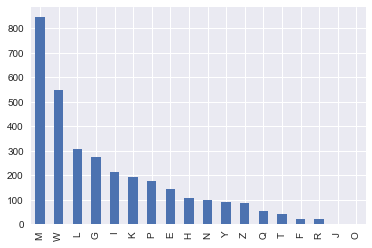

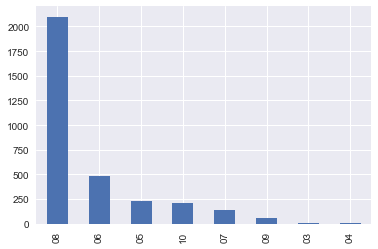

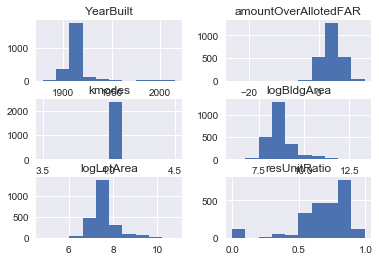

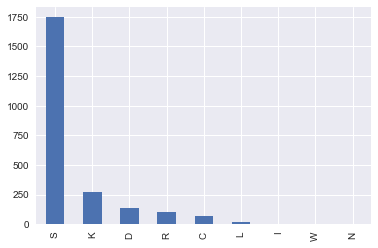

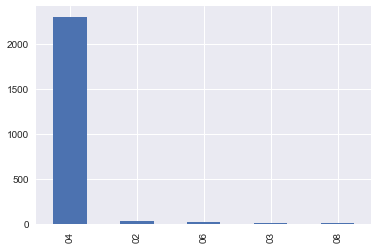

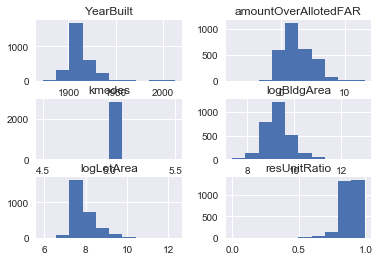

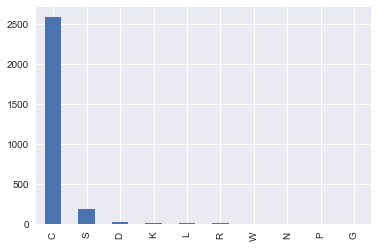

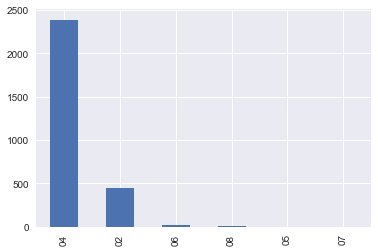

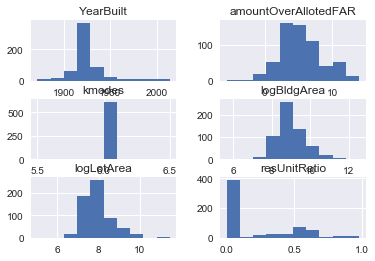

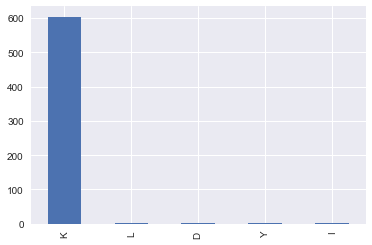

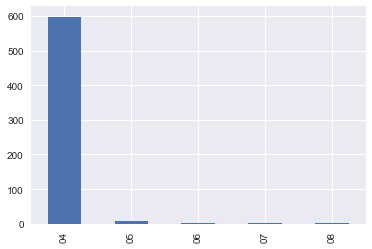

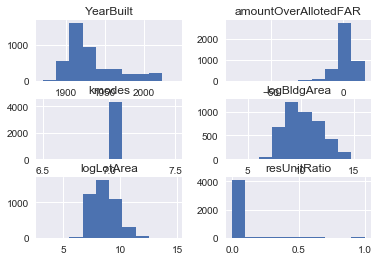

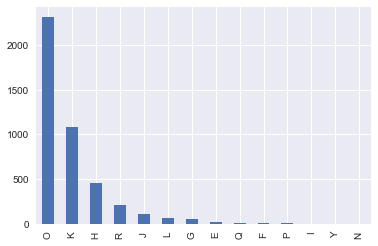

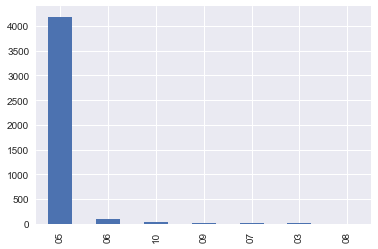

In [146]:
for n in range(n_clusters):
    plt.figure()
    X[X.kmodes == n].hist()
    plt.figure()
    X[X.kmodes == n]['simpleBldgClass'].value_counts().plot(kind = 'bar')
    plt.figure()
    X[X.kmodes == n]['LandUse'].value_counts().plot(kind = 'bar')

### Guassian Mixture Models
(can choose a suitable number of clusters, following from [tutorial](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html)) 